In [1]:
import numpy as np
import random as rand
import random
import math
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from scipy import stat
from dataclasses import dataclass
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Constants

B $\rightarrow$ rate of biomass decay \
SIZE $\rightarrow$ dimension of environment \
TIME $\rightarrow$ Number of time steps to simulate 
K -> L(B) const
J -> L(B) const

In [3]:
B = 0.05
J = 0.5
K = 0.3

## Cell Information

Biomass $\textit{biomass: float} \rightarrow$ The amount of biomass at a particular cell \
Burn Status $\textit{on_fire: bool} \rightarrow$ Whether or not a particular cell is burning

In [22]:
@dataclass
class Cell:
    """Class for keeping track of an information in a cell."""
    curr_biomass: float
    max_biomass: float
    on_fire: bool
        
    def __init__(self, curr_biomass=0.0, max_biomass=1.0, on_fire=False):
        self.curr_biomass = curr_biomass
        self.max_biomass = max_biomass
        self.on_fire = on_fire
    
    def calculate_distribution(self):
        """
        Calculates the probability distribution for fire spread to neighboring cells based on current cell parameters.
        """
        pass
    
    def set_fire(self):
        self.on_fire = True
        
    def n_t(self):
        pass
    
    def l_b(self):
        return (self.curr_biomass / self.max_biomass) * J + K

class Normal(Cell):
    """Normal cell class"""
    def n_t(self):
        return random.choices(population=[0, 1, 2], weights=[0.85, 0.13, 0.02])

class HRB(Cell):
    """HRB cell class""" 
    def n_t(self):
        return random.choices(population=[0, 1, 2], weights=[0.9, 0.09, 0.01])
    
class Log(Cell):
    """Logged cell class"""
    def calculate_distribution(self):
        return random.choices(population=[0, 1, 2], weights=[0.5, 0.35, 0.15])

## Skewed F Distribution 

Taken from user B. Poe, generates a skewed distribution with parameterized mean, standard deviation, skew

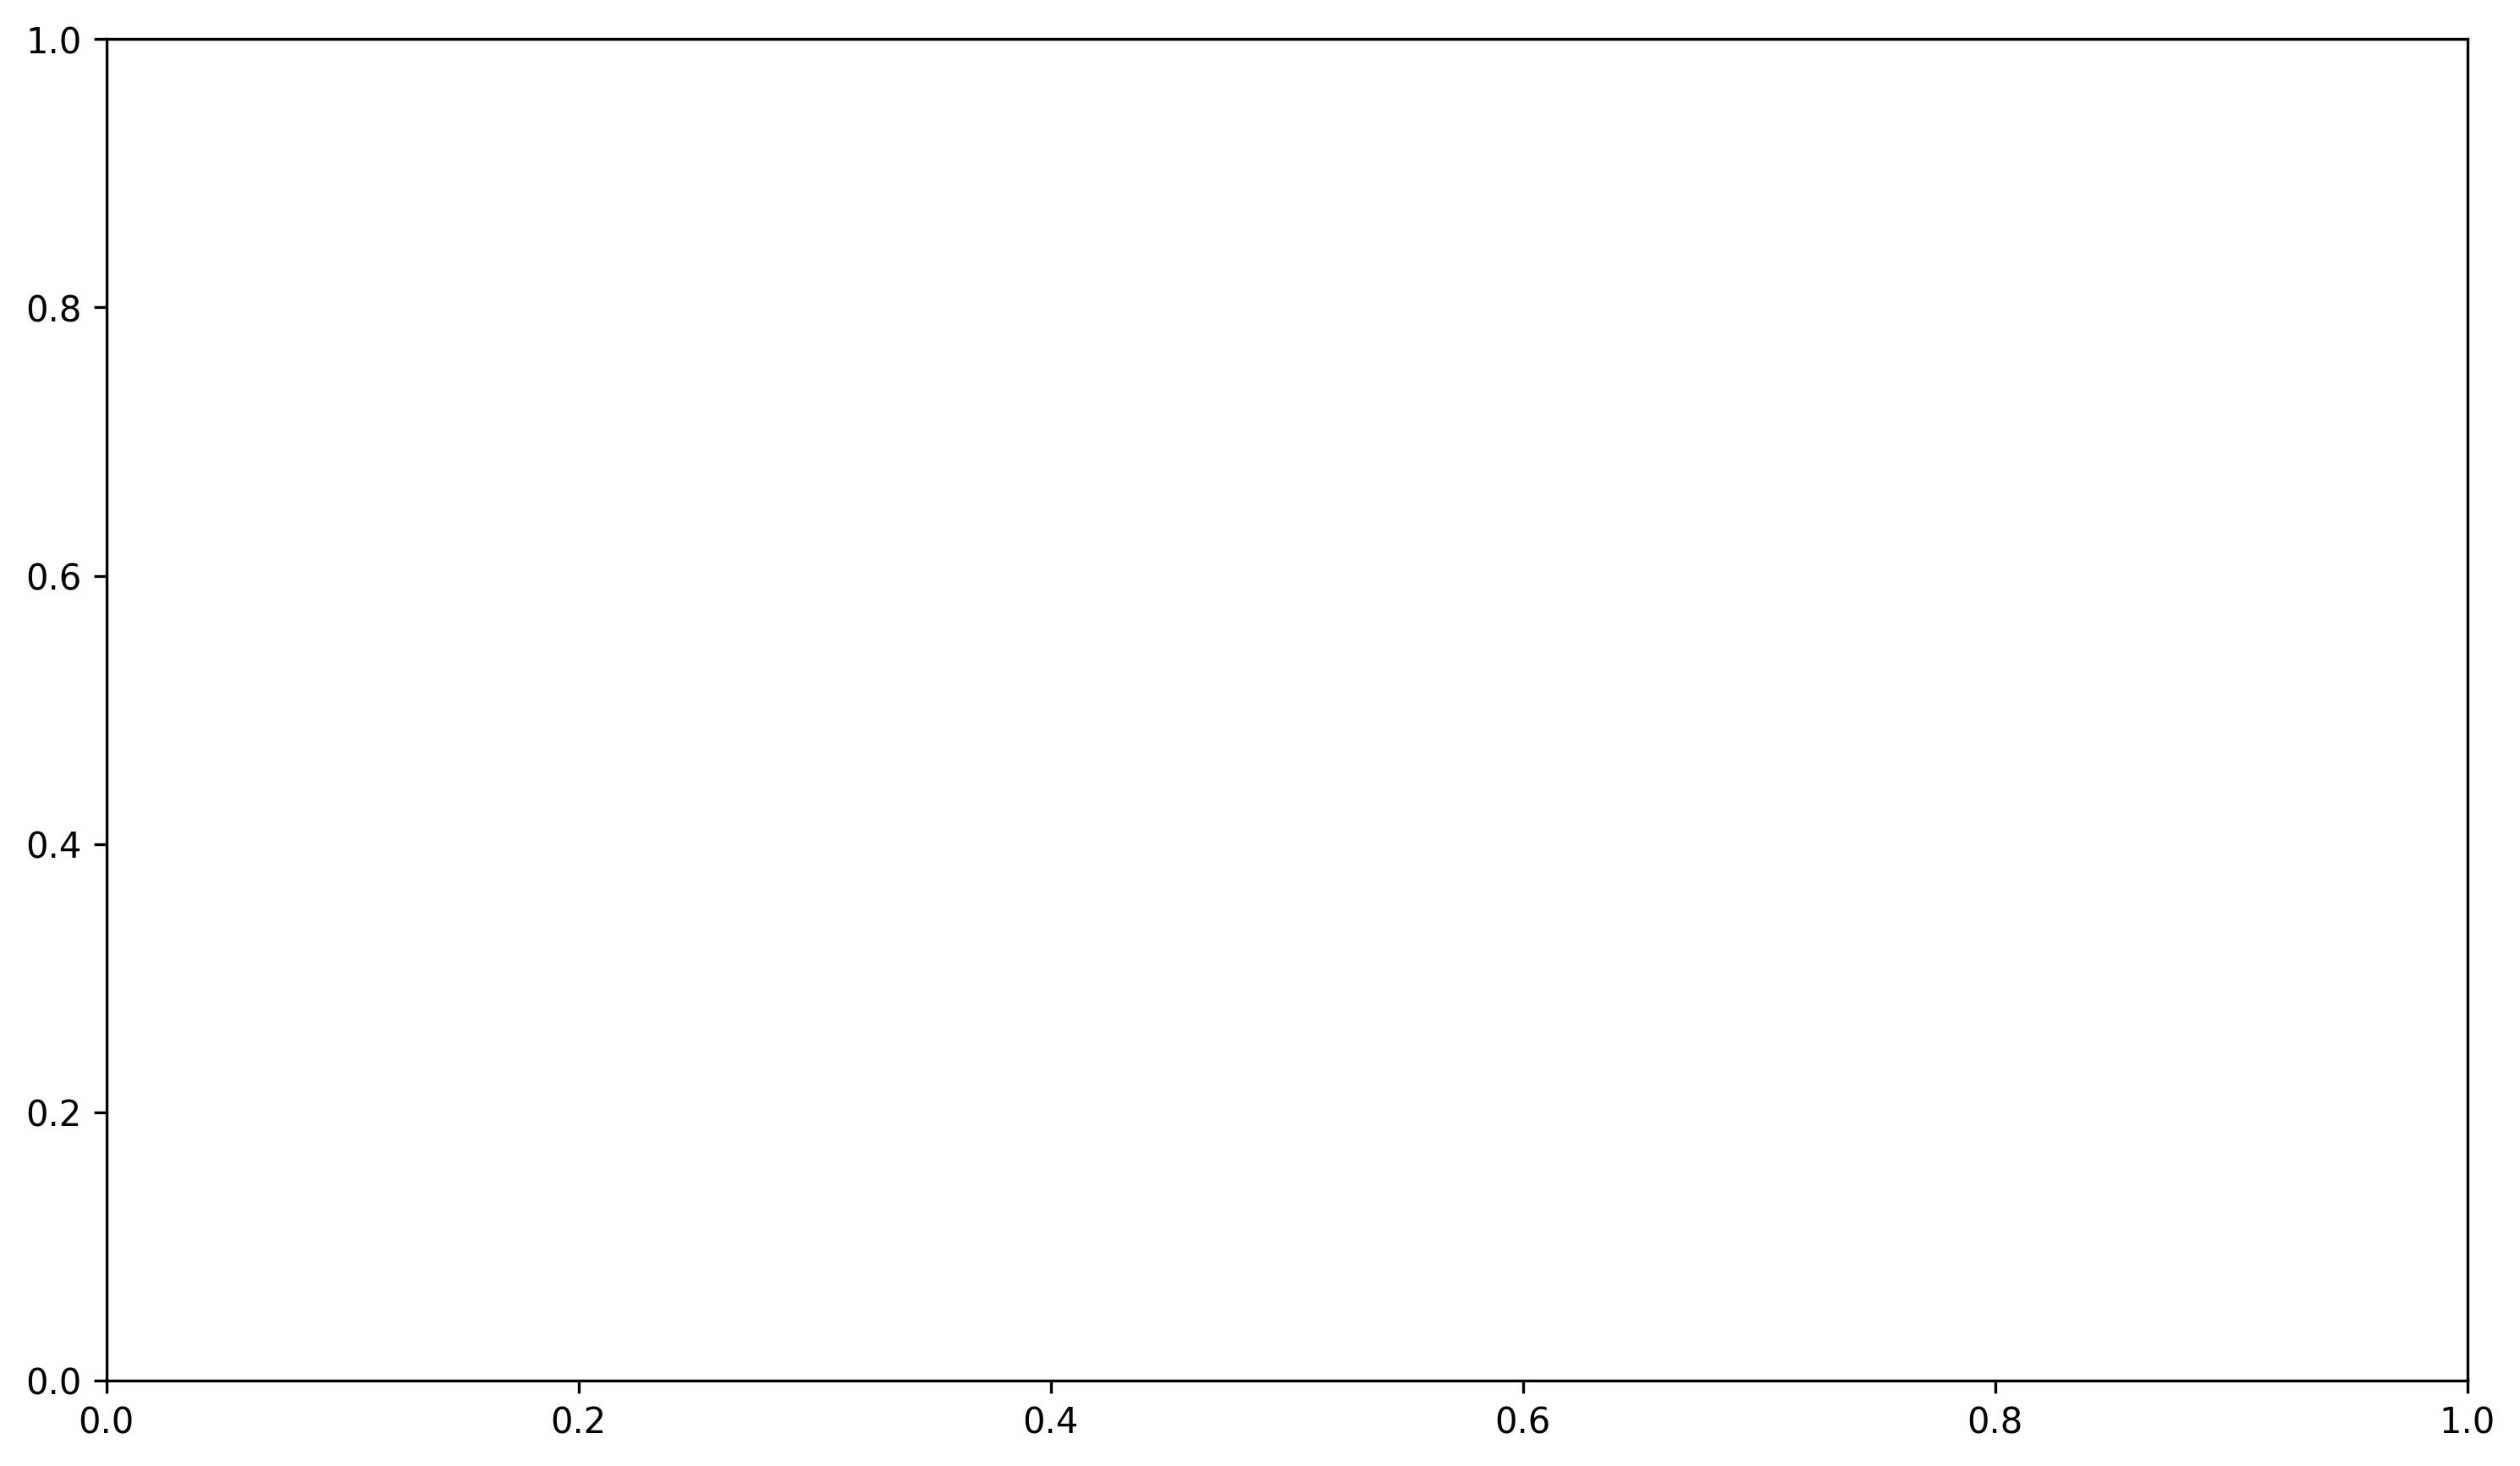

In [37]:
def createSkewDist(mean, sd, skew, size):

    # calculate the degrees of freedom 1 required to obtain the specific skewness statistic, derived from simulations
    loglog_slope=-2.211897875506251 
    loglog_intercept=1.002555437670879 
    df2=500
    df1 = 10**(loglog_slope*np.log10(abs(skew)) + loglog_intercept)

    # sample from F distribution
    fsample = np.sort(stats.f(df1, df2).rvs(size=size))

    # adjust the variance by scaling the distance from each point to the distribution mean by a constant, derived from simulations
    k1_slope = 0.5670830069364579
    k1_intercept = -0.09239985798819927
    k2_slope = 0.5823114978219056
    k2_intercept = -0.11748300123471256

    scaling_slope = abs(skew)*k1_slope + k1_intercept
    scaling_intercept = abs(skew)*k2_slope + k2_intercept

    scale_factor = (sd - scaling_intercept)/scaling_slope    
    new_dist = (fsample - np.mean(fsample))*scale_factor + fsample

    # flip the distribution if specified skew is negative
    if skew < 0:
        new_dist = np.mean(new_dist) - new_dist

    # adjust the distribution mean to the specified value
    final_dist = new_dist + (mean - np.mean(new_dist))

    return final_dist

desired_mean = 7
desired_skew = 1.05
desired_sd = 6

final_dist = createSkewDist(mean=desired_mean, sd=desired_sd, skew=desired_skew, size=1000000)
fig, ax = plt.subplots(figsize=(12,7))

In [39]:
TYPES = [HRB, Normal, Log]
    
class Env:
    """Environment class"""
    size: int
    max_time: int
        
    def __init__(self, size: int, max_time=100):
        self.size = size
        self.map = np.array([[random.choice(TYPES)(curr_biomass=0.0, max_biomass=1.0, on_fire=bool(random.getrandbits(1))) for _ in range(self.size)] \
                             for _ in range(self.size)], dtype=object)
        #locations of currently burning cells
        self.curr_burn = [(i, j) for i in range(self.size) \
                              for j in range(self.size) if self.map[i, j].on_fire is True] 
    
    def simulate(self):
        while t < self.max_time:
            curr_add_burn = set() # keep current burned during a single tick in a set so no instantaneous burn
            #look at what's burning already since only those cells can change state
            for (i, j) in self.curr_burn:
                #check the adjacent cells to see if they're on fire and set fire
                #LOCAL SPREAD
                if not self.map[i - 1, j].on_fire and (i - 1 >= 0): #left
                    set_fire_prob = self.map[i, j].l_b / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i - 1, j))
                if not self.map[i, j - 1].on_fire and (j - 1 >= 0): #top
                    set_fire_prob = self.map[i, j].l_b / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i, j - 1))
                if not self.map[i + 1, j].on_fire and (j - 1 < self.size): #right
                    set_fire_prob = self.map[i, j].l_b / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i + 1, j))     
                if not self.map[i, j + 1].on_fire and (j - 1 < self.size): #bottom
                    set_fire_prob = self.map[i, j].l_b / 4.0
                    if random.random() < set_fire_prob:
                        curr_add_burn.add((i, j + 1))
                #NONLOCAL SPREAD
                num_nonlocal = self.map[i, j].n_t()
                man_dist = math.floor(abs(np.random.choice(final_dist)))
                
            for (i, j) in curr_add_burn:
                self.map[i, j].set_fire()
            t += 1
    
    def populate_state(self, plot_type="terrain"):
        ret = np.array([[0 for _ in range(self.size)] for _ in range(self.size)])
        if plot_type == "burn":
            for i in range(self.size):
                for j in range(self.size):
                    if self.map[i, j].on_fire:
                        ret[i, j] = 0
                    else:
                        ret[i, j] = 1
        else:
            for i in range(self.size):
                for j in range(self.size):
                    if isinstance(self.map[i, j], Normal):
                        ret[i, j] = 0
                    elif isinstance(self.map[i, j], HRB):
                        ret[i, j] = 1
                    elif isinstance(self.map[i, j], Log):
                        ret[i, j] = 2
        return ret
    
    def plot_simulations(self, t=0, plot_type="terrain"):
        # create discrete colormap
        curr_state = self.populate_state()
        terrain_colors = colors.ListedColormap(['#24422c', '#4a8a5b', '#aab560'])
        if plot_type == "burn":
            curr_state = self.populate_state("burn")
            terrain_colors = colors.ListedColormap(['#000000', '#4a8a5b'])
        fig, ax = plt.subplots()
        ax.imshow(curr_state, cmap=terrain_colors)
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
        plt.axis('off')
        plt.figtext(0.5, 0.01, "Land map at time t = " + str(t), wrap=True, horizontalalignment='center', fontsize=10)
        plt.show()

In [48]:
test = Env(1000)
test.map

array([[Log(curr_biomass=0.0, max_biomass=1.0, on_fire=True),
        HRB(curr_biomass=0.0, max_biomass=1.0, on_fire=False),
        Log(curr_biomass=0.0, max_biomass=1.0, on_fire=True), ...,
        Normal(curr_biomass=0.0, max_biomass=1.0, on_fire=False),
        Log(curr_biomass=0.0, max_biomass=1.0, on_fire=False),
        Log(curr_biomass=0.0, max_biomass=1.0, on_fire=True)],
       [HRB(curr_biomass=0.0, max_biomass=1.0, on_fire=True),
        Log(curr_biomass=0.0, max_biomass=1.0, on_fire=True),
        HRB(curr_biomass=0.0, max_biomass=1.0, on_fire=True), ...,
        Normal(curr_biomass=0.0, max_biomass=1.0, on_fire=True),
        Normal(curr_biomass=0.0, max_biomass=1.0, on_fire=False),
        Log(curr_biomass=0.0, max_biomass=1.0, on_fire=False)],
       [HRB(curr_biomass=0.0, max_biomass=1.0, on_fire=True),
        Normal(curr_biomass=0.0, max_biomass=1.0, on_fire=False),
        Normal(curr_biomass=0.0, max_biomass=1.0, on_fire=False), ...,
        HRB(curr_biomass=0.0, m

[[2 1 2 ... 0 2 2]
 [1 2 1 ... 0 0 2]
 [1 0 0 ... 1 2 2]
 ...
 [2 0 2 ... 1 2 2]
 [0 1 2 ... 2 0 1]
 [1 2 0 ... 1 1 0]]


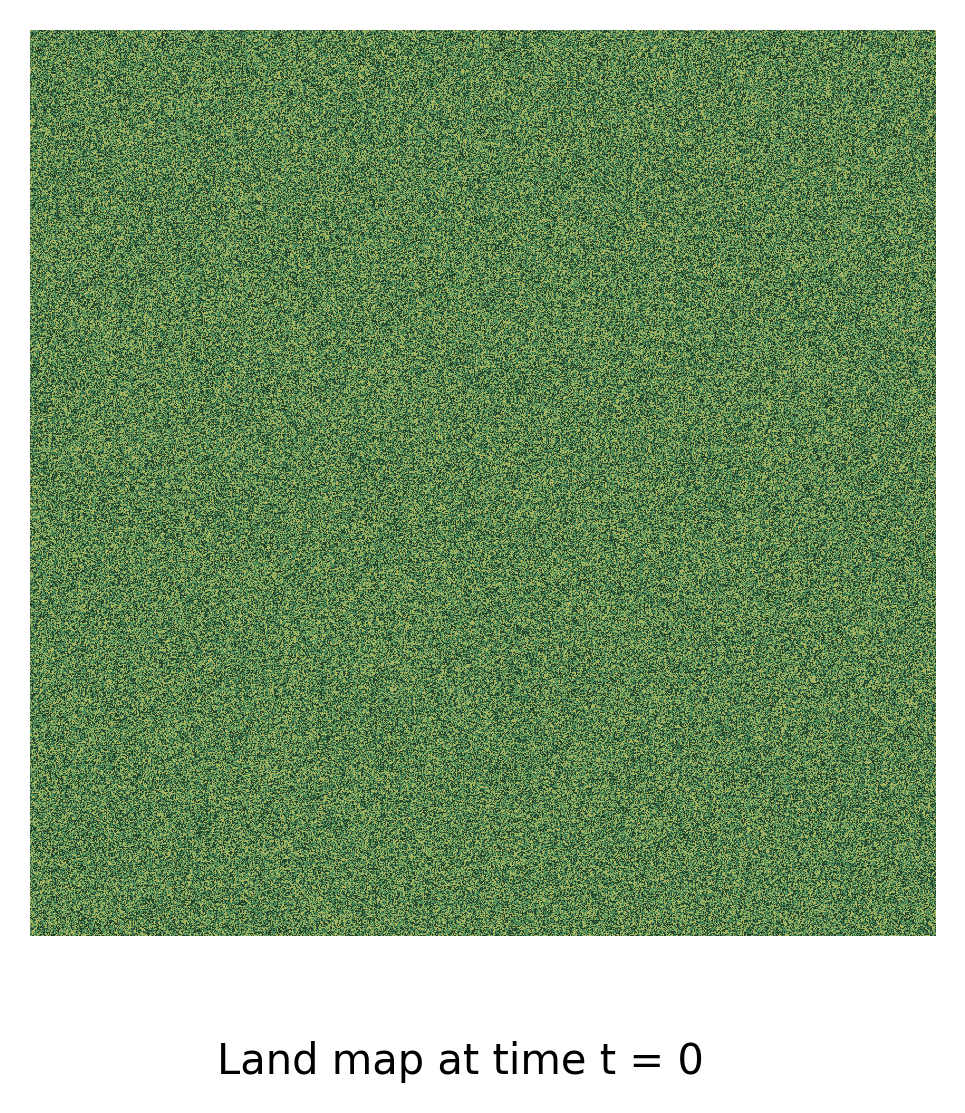

In [49]:
test.plot_simulations()